# Parent Classes

In [1]:
import numpy as np

class Layer:
    '''
    This is the Layer abstract class. All our layers will have this as their parent class. 
    Note we can already say that we will need a "forward" and "backward" method for each layer,
    since data must be passed forward and backward. 
    '''
    def __init__(self):
        self.trainable = True
 
    def __str__(self):
        raise NotImplementedError
    
    def forward(self, inputs):
        raise NotImplementedError
        
    def backward(self, grad):
        raise NotImplementedError

class Model:
    '''
    This is the Model class. It assumes to call Layer objects from the list of layers stored in "self.layers".
    Note that we have three main (visible) methods:
    
    add = This method adds a Layer class instance to self.layers. 
    predict = This method computes the forward pass for the input data. 
    fit = This method trains the model by using the "backward" method of each layer.
    
    Finally, there is also a hidden method: _fit_on_epoch. This method performs one batch gradient descent
    update for a given batch of data. We repeat this function "epochs" number of times in the "fit" method.
    '''
    def __init__(self):
        self.layers = []
        self.loss = []
     
    def add(self, layer):
        self.layers.append(layer)
     
    def predict(self, X):
        '''
        This model predicts the data. 
        Note X must be of shape (batch_size, n_features)
        '''
        # Forward pass
        layer_input = X.copy()
        for i, _ in enumerate(self.layers):
            layer_input = self.layers[i].forward(layer_input)
             
        return layer_input
     
    def fit(
        self, 
        X_train, 
        Y_train, 
        loss_fn,
        learning_rate, 
        epochs, 
        verbose=False
    ):
        '''
        This method trains a model. 
        Shape of X_train = (batch_size, n_features)
        Shape of Y_train = (batch_size, C), 
        where C = 1 for regression and binary classification and 
        C = n_classes for multi-class classification.
        
        '''
        for epoch in range(epochs):
            loss = self._fit_on_epoch(X_train, Y_train, learning_rate, loss_fn)
             
            if verbose:
                if epoch % 500 == 0:
                    print(f'Epoch: {epoch}. Loss: {loss}')
     
    def _fit_on_epoch(self, X, Y, learning_rate, loss_fn):
        # Note this method will be hidden because it starts with one underscore. 
        # Forward pass
        forward = X.copy()
        for i, _ in enumerate(self.layers):
            forward = self.layers[i].forward(forward)
             
        # Compute loss and first gradient
        # Compute the loss using loss.forward()
        # Get the gradient of the loss with respect to model outputs with loss.backward(); store for layers' backprop
        # Append the current loss for the epoch to a list.
        error = loss_fn.forward(forward, Y)
        gradient = loss_fn.backward()
        self.loss.append(error)
        # Backpropagation
        # Current gradient is "gradient" returned from the loss
        # We reverse through each layer saved in the self.layers list. 
        # If it is not a linear layer (no weights); compute the downstream grad
        # If it is a linear layer (hidden); compute downstream grad wrt inputs as well as downstream grad of weights;
        # Update weights if linear.
        for i, _ in reversed(list(enumerate(self.layers))):
            if self.layers[i].type != 'Linear': # If not a linear layer, pass the gradient on to previous layer.
                gradient = self.layers[i].backward(gradient)
            else: # If linear, pass back gradient of data, W, and B; then update W and B. 
                gradient, grad_weights, grad_bias = self.layers[i].backward(gradient)
                self.layers[i].apply_gradients(grad_weights, grad_bias, learning_rate)
        return error

# Linear Layer

In [2]:
class Linear(Layer):
    '''
    This is the linear Layer class. 
    Note it is like the Dense layer in Keras without any activation function. 
    This layer returns Z = XW + b.
    '''
    def __init__(self, in_features, out_features):
        # Note we use super() since we need the self.trainable attribute of the abstract class Layer
        super().__init__()
        self.weights = np.random.randn(in_features, out_features)
        self.bias = np.zeros((1, out_features)) # Note, it is a row vector so that we broadcast along the rows
        self.type = 'Linear'
    
    def __str__(self):
        return f'{self.type} Layer'
    
    def forward(self, inputs):
        # Forward propagation to get output of layer
        self.inputs = inputs
        return np.matmul(inputs, self.weights) + self.bias
    
    def backward(self, grad):
        # Given the upstream gradient = grad, compute downstream gradient = grad_inputs
        # Since this layer has trainable weights, also compute grad of W = grad_weights
        # and grad of b = grad_bias; then update these two trainable tensors. 
        grad_inputs = np.matmul(grad, self.weights.T)
        grad_weights = np.matmul(self.inputs.T, grad)
        grad_bias = np.sum(grad, axis=0, keepdims=True)
        return grad_inputs, grad_weights, grad_bias
    
    def apply_gradients(self, grad_weights, grad_bias, lr):
        # Since we have trainable weights, update them with batch gradient descent.
        if self.trainable:
            self.weights -= lr * grad_weights
            self.bias -= lr * grad_bias

# Activations

In [3]:
class ReLU(Layer):
    '''
    This is the Rectified Linear Unit (ReLU) activation function. 
    '''
    def __init__(self):
        self.type = 'ReLU'
 
    def __str__(self):
        return f'{self.type} Layer'
    
    def forward(self, inputs):
        self.inputs = inputs
        return np.maximum(0, inputs)
    
    def backward(self, grad):
        # Could do: grad * np.heaviside(self.inputs, 0); computationally expensive
        grad_inputs = grad * (self.inputs > 0)
        return grad_inputs

# Losses

In [4]:
class MeanSquaredError(Layer):
    '''
    This is the Mean Squared Error Loss. Note we also treat it as a layer. 
    However, the forward and backward methods work slightly differently.
    The main difference is that the forward method receives the "inputs"
    which are the outputs of the neural network, and the "targets" 
    which are the actual values for the response variable. 
    '''
    def __init__(self):
        pass
    
    def forward(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        return 0.5*np.mean((inputs - targets) ** 2)
    
    def backward(self):
        return (self.inputs - self.targets) / self.inputs.shape[0]

class MeanAbsoluteError(Layer):
    '''
    This is the Mean Absolute Error Loss. Note we also treat it as a layer. 
    However, the forward and backward methods work slightly differently.
    '''
    def __init__(self):
        pass
    
    def forward(self, inputs, targets):
        self.inputs = inputs # Predictions
        self.targets = targets # Labels
        return np.mean(np.abs(inputs - targets))
    
    def backward(self):
        return np.sign(self.inputs - self.targets) / self.inputs.shape[0]

# Regression Example

In [5]:
def generate_regression_data(n, scale=0.25, seed=4433):
    np.random.seed(seed)
    x = np.random.uniform(-3,3,(n,))
    err = np.random.normal(0., scale, (n,))
    y = 0.2*x**3 + 0.8*x**2 + 1 + err
    
    mux = np.mean(x)
    muy = np.mean(y)
    sigx = np.std(x)
    sigy = np.std(y)
    x = (x-mux)/sigx
    y = (y-muy)/sigy
    return x,y

x,y = generate_regression_data(1000)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

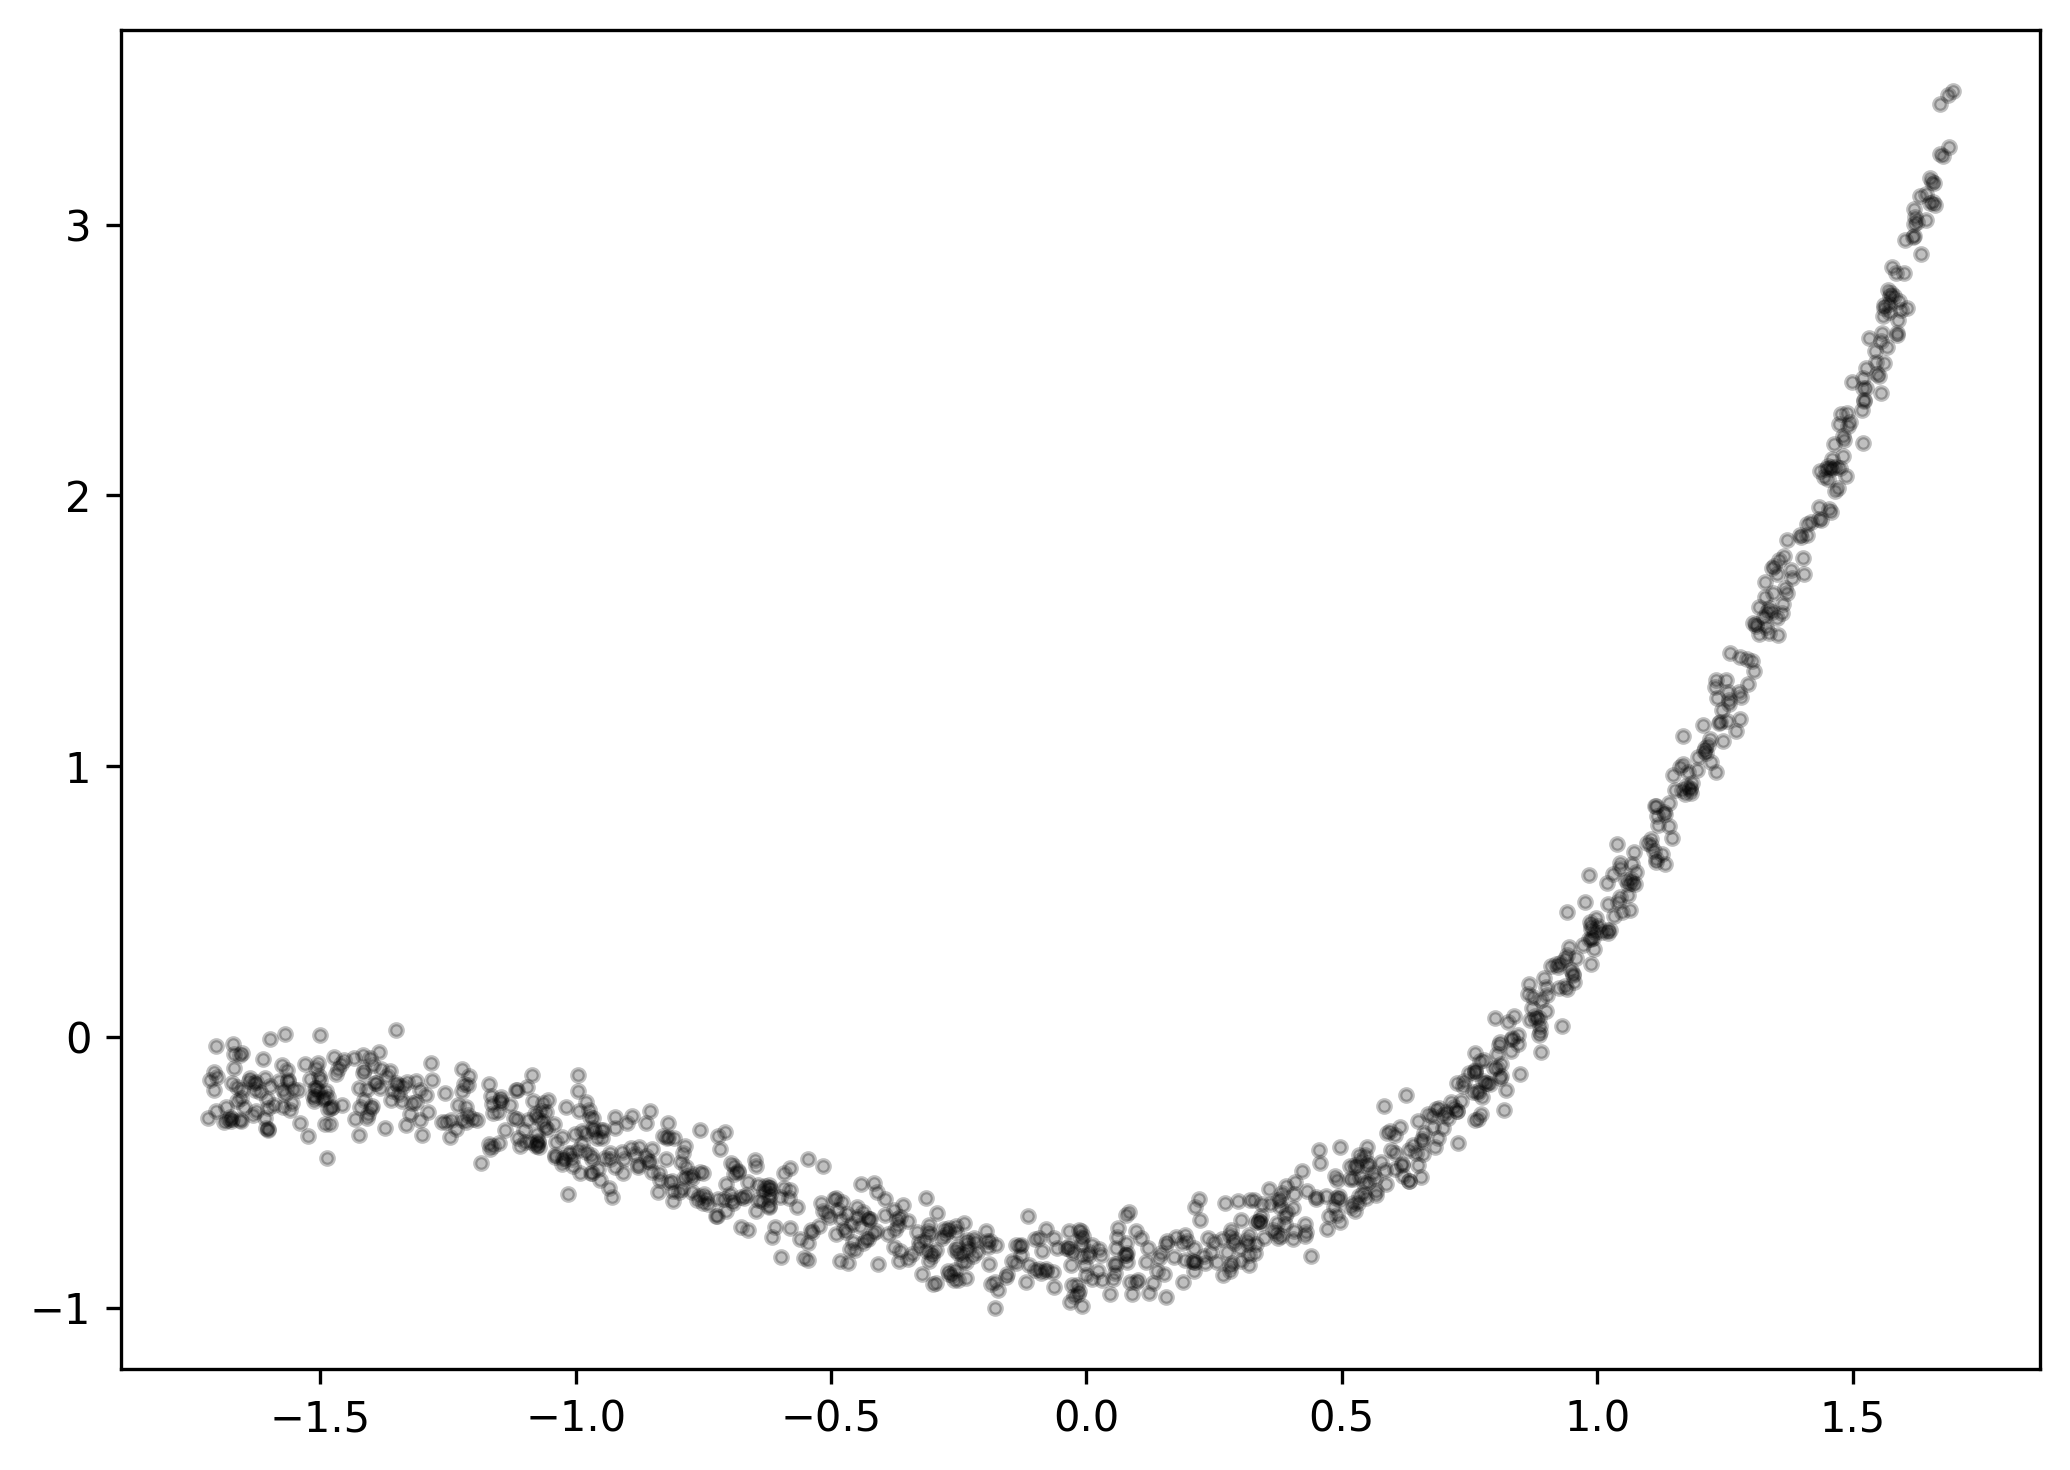

In [8]:
plt.figure(dpi=300, figsize=(7,5))
plt.scatter(x,y, c='black', alpha=0.25, marker='.')
plt.tight_layout()
plt.savefig('./Plots/regression_example_data.pdf', bbox_inches='tight')
plt.show()

In [9]:
### Reshape data
print(f'Current shape:\nx = {x.shape}\ny = {y.shape}')
x = x.reshape(-1,1)
y = y.reshape(-1,1)
print(f'New shape:\nx = {x.shape}\ny = {y.shape}')

Current shape:
x = (1000,)
y = (1000,)
New shape:
x = (1000, 1)
y = (1000, 1)


In [10]:
# Create model
model = Model()

# Add layers
model.add(Linear(1, 16))
model.add(ReLU())

model.add(Linear(16, 16))
model.add(ReLU())

model.add(Linear(16, 16))
model.add(ReLU())

model.add(Linear(16,1))

In [11]:
# Train model
model.fit(X_train = x, 
          Y_train = y, 
          loss_fn = MeanSquaredError(),
          learning_rate = 0.004, 
          epochs=1500,
          verbose=True)

Epoch: 0. Loss: 34.000626895317986
Epoch: 500. Loss: 0.010543764655874675
Epoch: 1000. Loss: 0.0064267064167960655


In [12]:
xseq = np.linspace(x.min()-1e-02,x.max()+1e-02,100)
yseq = model.predict(xseq.reshape(-1,1))

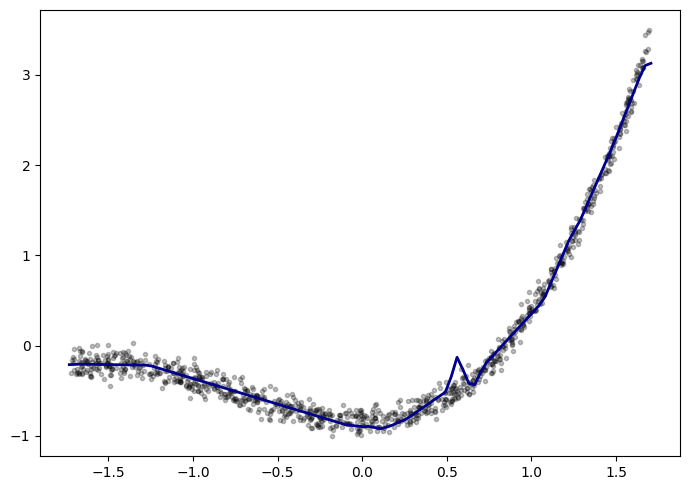

In [13]:
plt.figure(figsize=(7,5))
plt.scatter(x,y, c='black', alpha=0.25, marker='.')
plt.plot(xseq, yseq.ravel(), color='darkblue', linewidth=2.0)
plt.tight_layout()
plt.savefig('./Plots/regression_example_predictions.pdf', bbox_inches='tight')
plt.show()

In [14]:
class Sigmoid(Layer):
    '''
    This is the Sigmoid activation function. 
    '''
    def __init__(self):
        self.type = 'Sigmoid'
 
    def __str__(self):
        return f'{self.type} Layer'
    
    def forward(self, inputs):
        self.outputs = 1 / (1 + np.exp(-inputs))
        return self.outputs
    
    def backward(self, grad):
        grad_inputs = grad * self.outputs * (1 - self.outputs)
        return grad_inputs

class BinaryCrossEntropy(Layer):
    '''
    This is the binary cross-entropy loss function.
    It assumes that both "inputs" and "targets" are column vectors. 
    '''
    def __init__(self):
        pass
    
    def forward(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        self.eps = 1e-8 # Added to avoid log(0)
        return -np.mean(targets * np.log(inputs + self.eps) + (1 - targets) * np.log(1 - inputs + self.eps))
    
    def backward(self):
        return (self.inputs - self.targets) / (self.inputs * (1 - self.inputs) + self.eps) / self.inputs.shape[0]

In [15]:
from sklearn.datasets import make_moons, make_circles, make_blobs

def generate_multiclass_data(n, n_classes, seed=9090, cluster_std=3.5):
    np.random.seed(seed)
    X, y = make_blobs(n_samples=n, centers=n_classes, n_features=2, cluster_std=cluster_std)
    return X,y

In [16]:
X, y = generate_multiclass_data(3000, 2)

In [17]:
# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))

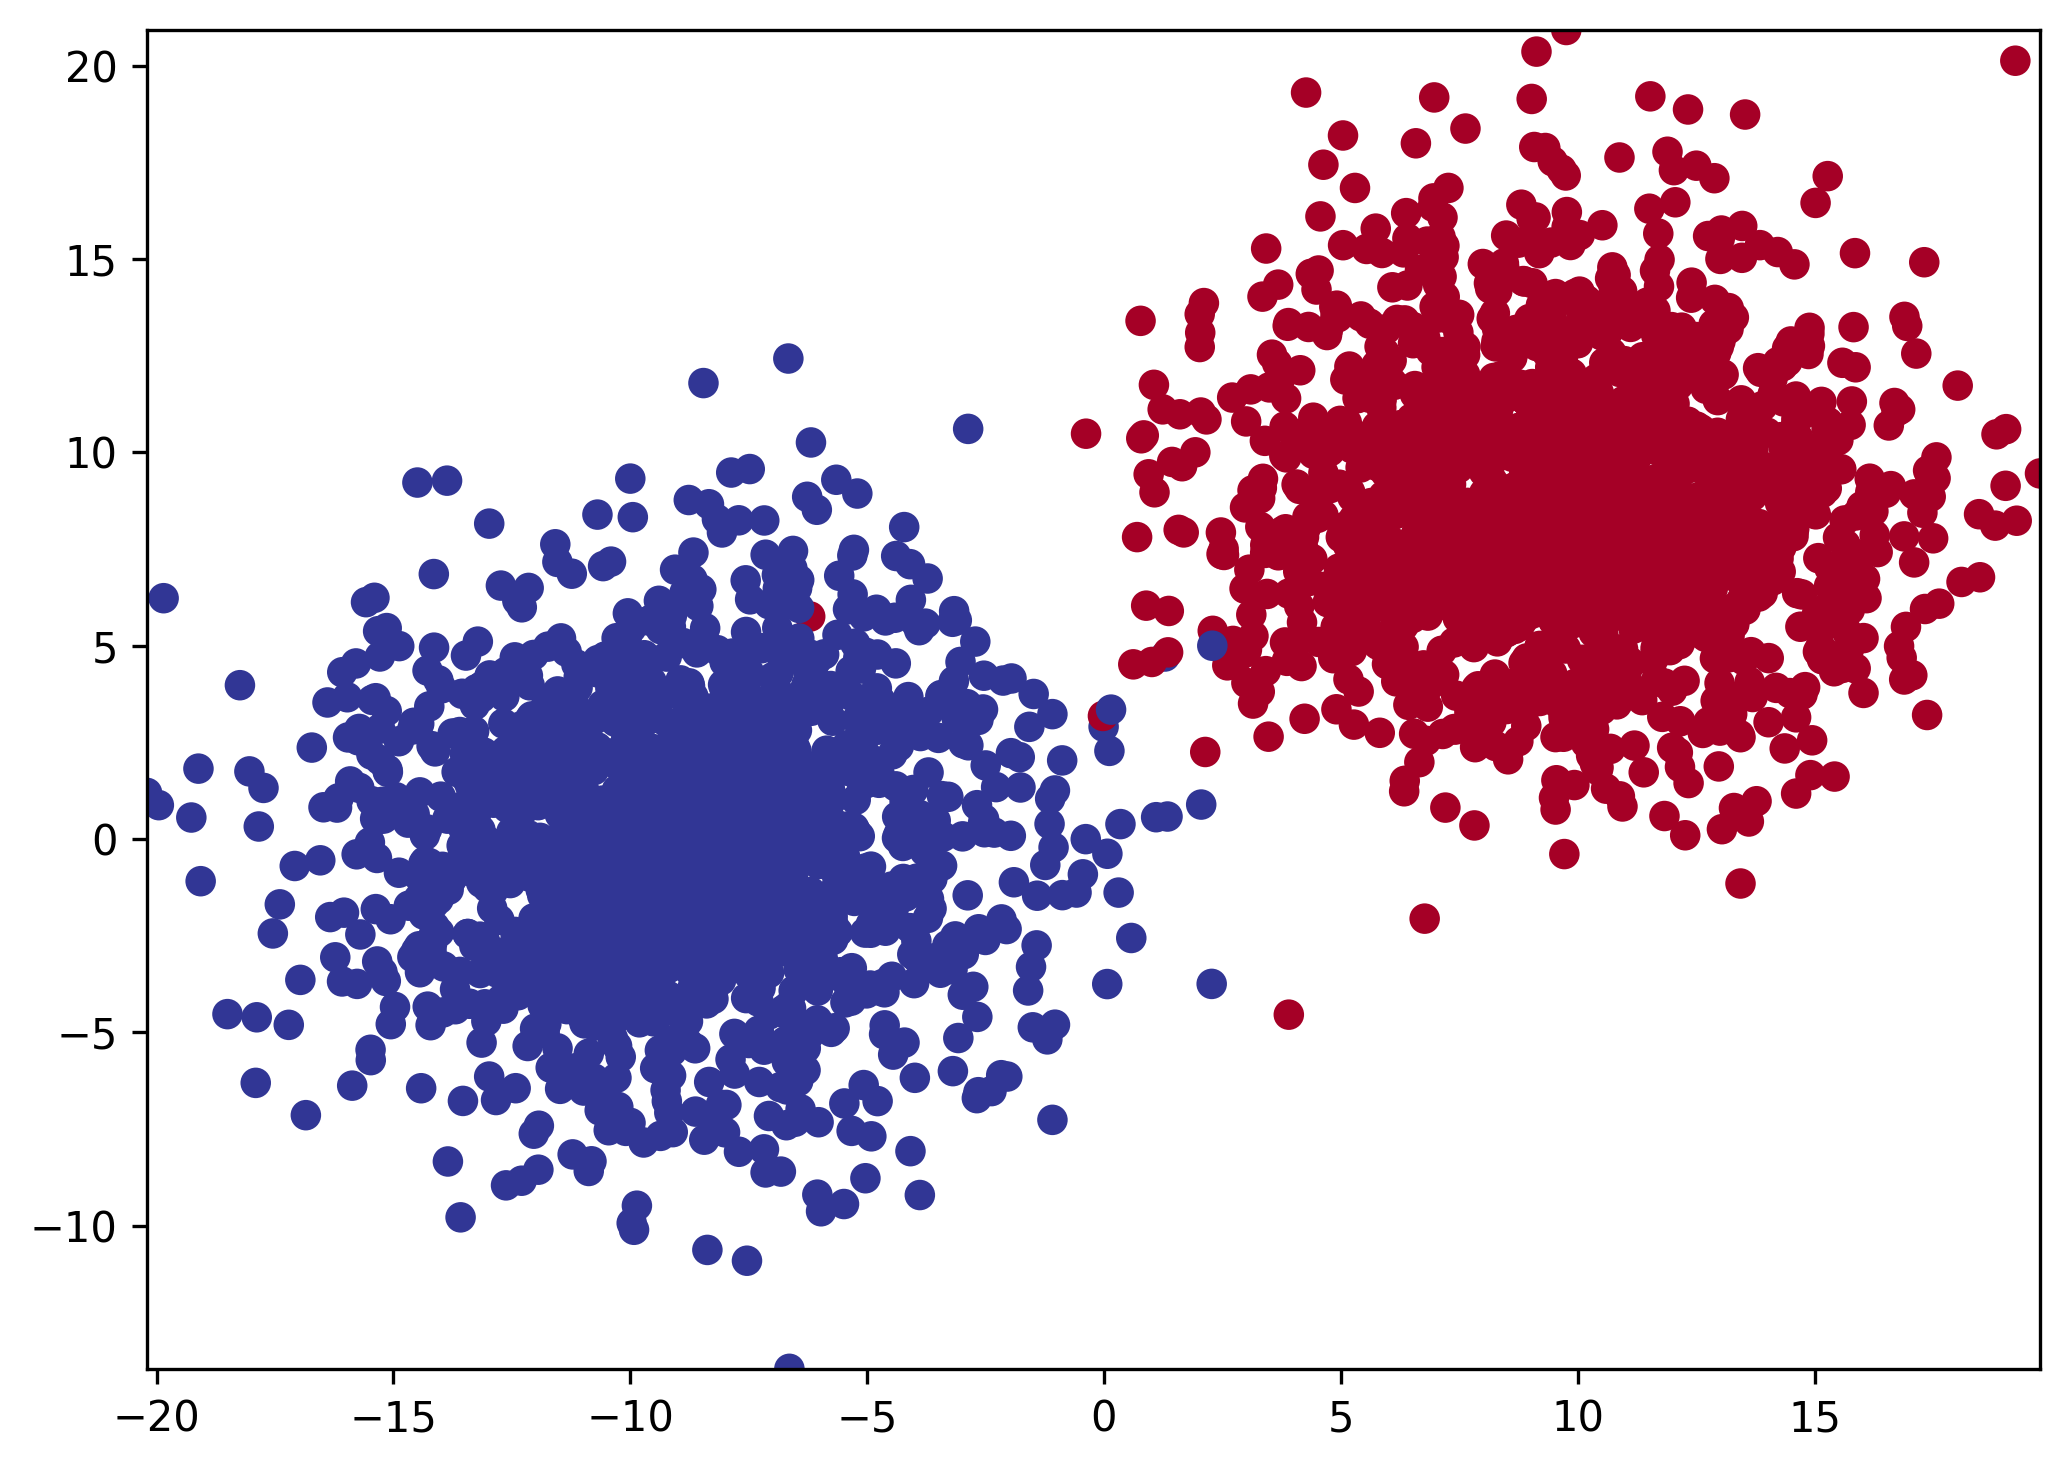

In [18]:
plt.figure(dpi=300, figsize=(7,5))
plt.scatter(df.x, df.y, c=df.label, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(df.x.min(), df.x.max())
plt.ylim(df.y.min(), df.y.max())
plt.tight_layout()
plt.savefig('./Plots/binary_classification_example_data.pdf', bbox_inches='tight')
plt.show()

In [19]:
print(f'Current shape:\nx = {X.shape}\ny = {y.shape}')
y = y.reshape(-1,1)
print(f'New shape:\nx = {X.shape}\ny = {y.shape}')

Current shape:
x = (3000, 2)
y = (3000,)
New shape:
x = (3000, 2)
y = (3000, 1)


In [20]:
# Create model
model = Model()
# Add layers
model.add(Linear(2, 16))
model.add(ReLU())
model.add(Linear(16,16))
model.add(ReLU())
model.add(Linear(16,1))
model.add(Sigmoid())

In [21]:
# Train model
model.fit(X_train = X, 
          Y_train = y, 
          loss_fn=BinaryCrossEntropy(),
          learning_rate = 0.05, 
          epochs=3000,
          verbose=True)

Epoch: 0. Loss: 16.771790628216454
Epoch: 500. Loss: 0.02040448473027494
Epoch: 1000. Loss: 0.017739641329596444
Epoch: 1500. Loss: 0.016726377621802558
Epoch: 2000. Loss: 0.016262451919902367
Epoch: 2500. Loss: 0.015966874086324048


In [22]:
probs = model.predict(X)
probs.shape

(3000, 1)

In [23]:
preds = np.array([1 if u>0.5 else 0 for u in probs.ravel()])
np.mean(preds == y.ravel())

0.9976666666666667

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
confusion_matrix(y.ravel(), preds)

array([[1498,    2],
       [   5, 1495]], dtype=int64)

In [26]:
def plot_2D_binary_decision_boundary(X, y, model, save_path=None):
    x_min, x_max = X[:, 0].min() - 0.1, X[:,0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    
    xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_prob = model.predict(x_in)
    y_pred = np.array([1 if u>=0.5 else 0 for u in y_prob]).reshape(xx.shape)
    
    plt.figure(dpi=300, figsize=(7,5))
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:,0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

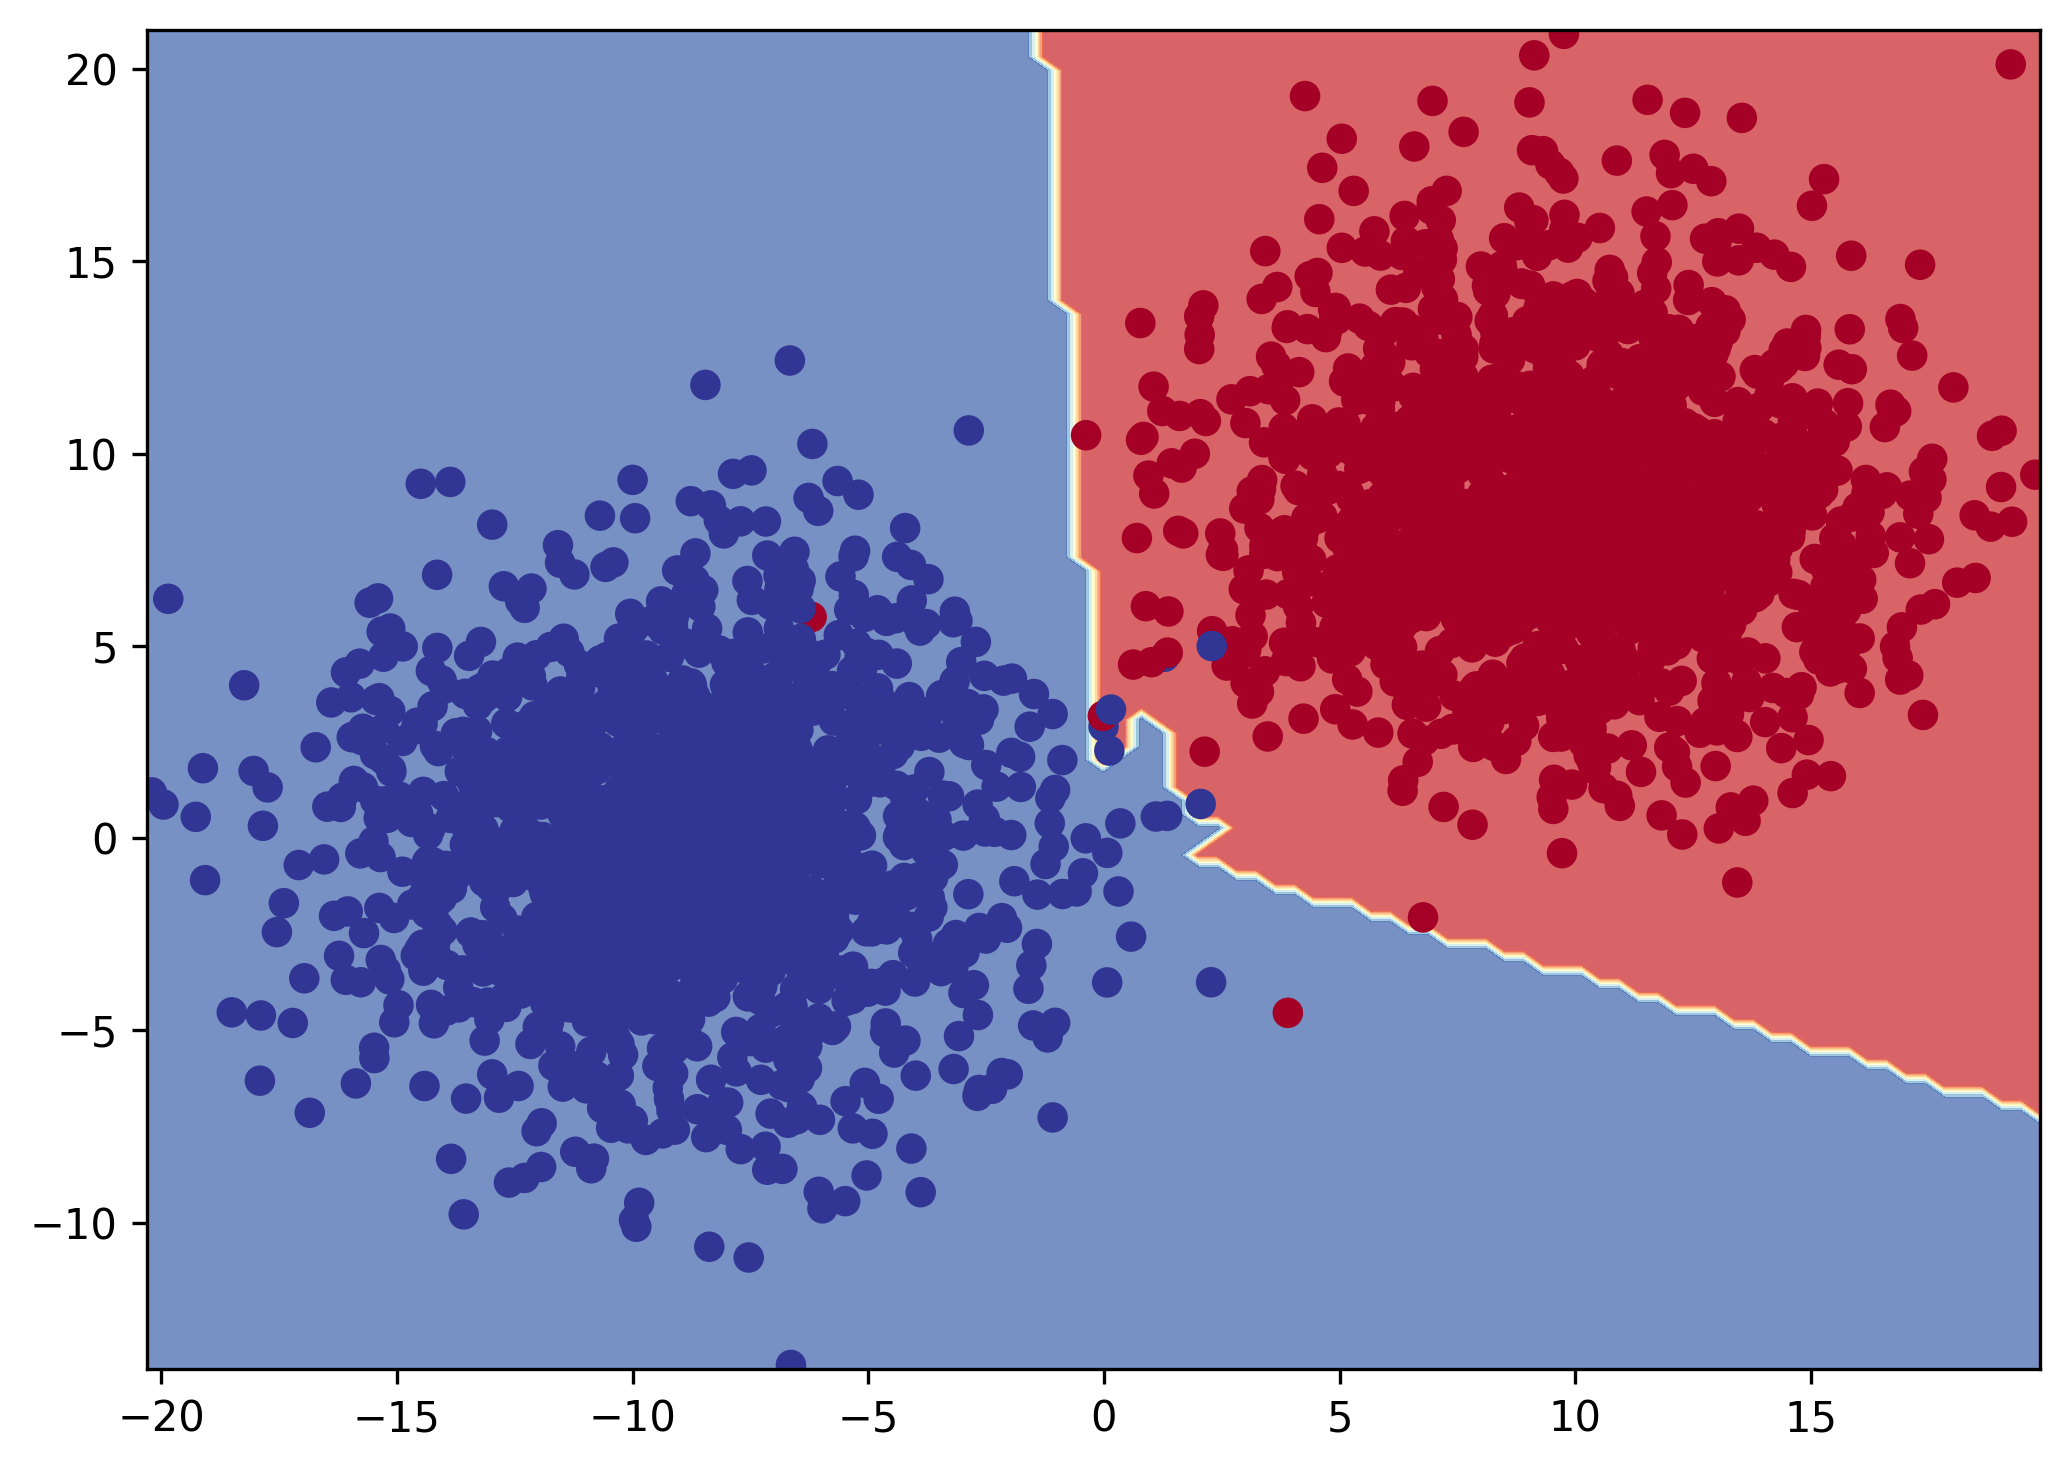

In [27]:
plot_2D_binary_decision_boundary(X, y, model, save_path='./Plots/binary_classification_example_predictions.pdf')

In [28]:
class SoftMax(Layer):
    '''
    This is the softmax activation function. 
    Note it is programmed to only be used with the categorical cross-entropy loss. 
    '''
    def __init__(self):
        self.type = 'SoftMax'
 
    def __str__(self):
        return f'{self.type} Layer'
    
    def forward(self, inputs):
        exps = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.outputs = exps / np.sum(exps, axis=1, keepdims=True)
        return self.outputs
    
    def backward(self, grad):
        return grad

class CategoricalCrossEntropy(Layer):
    '''
    This is the categorical cross-entropy loss. 
    It is assumed that both "inputs" and "targets" are matrices of shape (batch_size, n_classes).
    '''
    def __init__(self):
        pass
    
    def forward(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        self.eps = 1e-8
        return -np.mean(np.sum(targets * np.log(inputs + self.eps), axis=1))
    
    def backward(self):
        return (self.inputs - self.targets) / self.inputs.shape[0]

In [29]:
n_classes = 3

X, y = generate_multiclass_data(5000, n_classes)

In [30]:
# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))

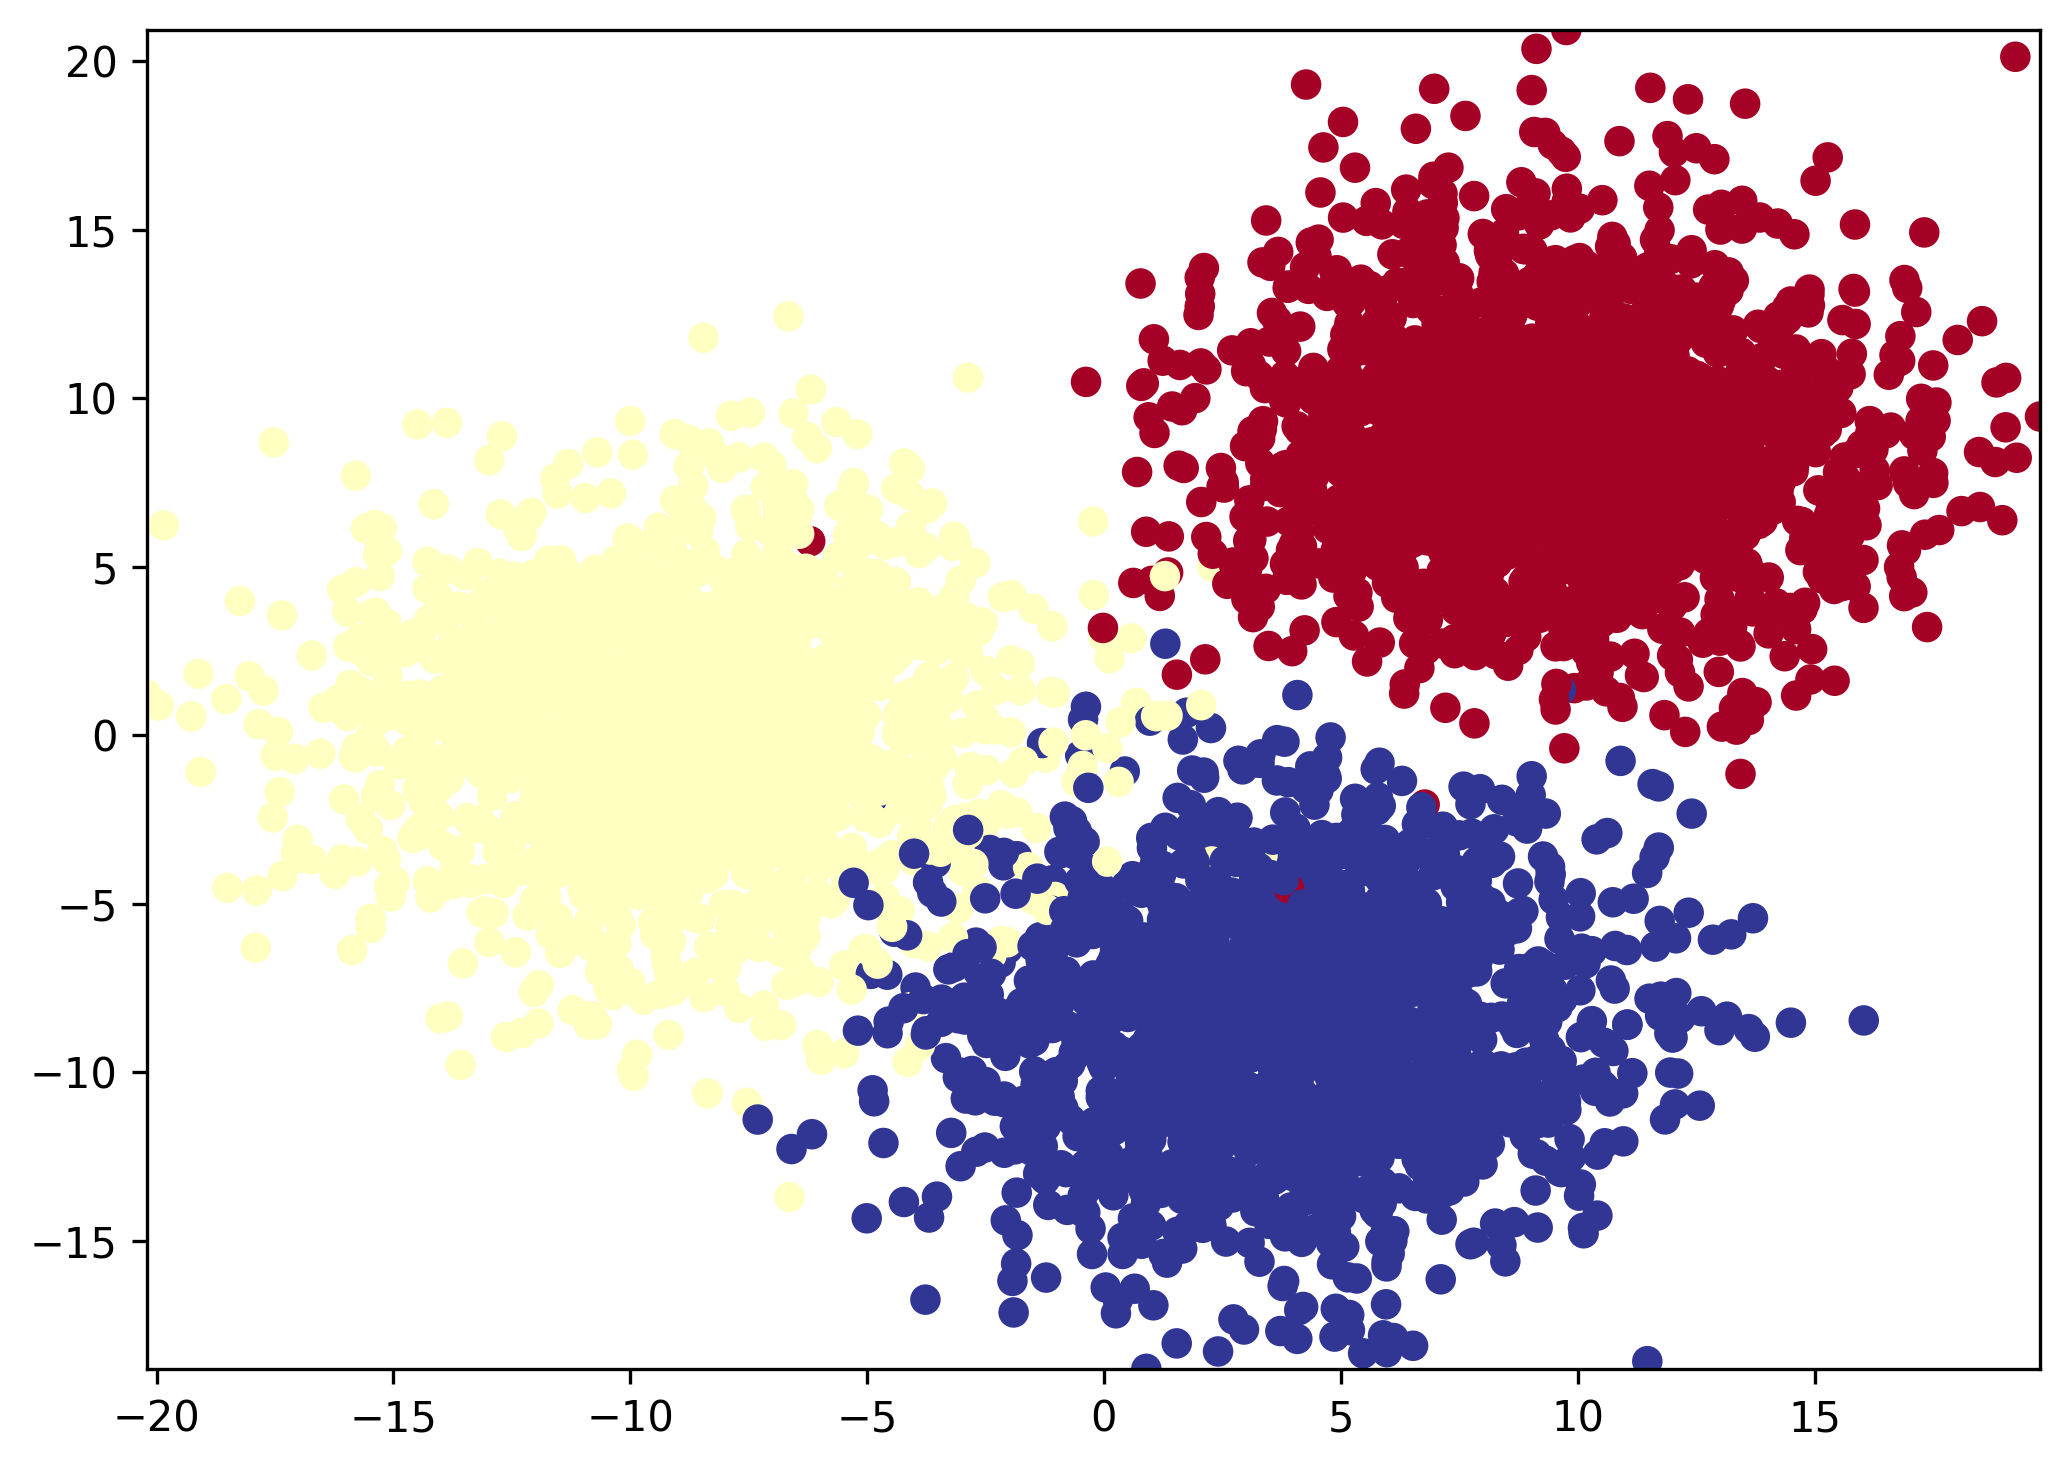

In [31]:
plt.figure(dpi=300, figsize=(7,5))
plt.scatter(df.x, df.y, c=df.label, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(df.x.min(), df.x.max())
plt.ylim(df.y.min(), df.y.max())
plt.tight_layout()
plt.savefig('./Plots/multiclass_classification_example_data.pdf', bbox_inches='tight')
plt.show()

In [32]:
print(f'Current shape of response: {y.shape}')

def one_hot_encode(labels, num_classes=None):
    # Find the number of classes if not provided
    if num_classes is None:
        num_classes = np.max(labels) + 1

    # Create a matrix of zeros
    one_hot_labels = np.zeros((labels.shape[0], num_classes))

    # Set the appropriate elements to 1
    one_hot_labels[np.arange(labels.shape[0]), labels] = 1

    return one_hot_labels

Y = one_hot_encode(y, n_classes)

print(f'New shape of response - now called "Y": {Y.shape}')

Current shape of response: (5000,)
New shape of response - now called "Y": (5000, 3)


In [33]:
# Create model
model = Model()
# Add layers
model.add(Linear(2, 16))
model.add(ReLU())
model.add(Linear(16,16))
model.add(ReLU())
model.add(Linear(16,n_classes))
model.add(SoftMax())

In [34]:
# Train model
model.fit(X_train = X, 
          Y_train = Y, 
          loss_fn = CategoricalCrossEntropy(),
          learning_rate = 0.0025, 
          epochs=3000,
          verbose=True)

Epoch: 0. Loss: 11.626886084346733
Epoch: 500. Loss: 0.06733944550196115
Epoch: 1000. Loss: 0.061858452866178096
Epoch: 1500. Loss: 0.05894708553871331
Epoch: 2000. Loss: 0.05615715569995916
Epoch: 2500. Loss: 0.053543034980547896


In [35]:
probs = model.predict(X)
probs.shape

(5000, 3)

In [36]:
preds = probs.argmax(axis=1)

In [37]:
np.mean(preds == y)

0.9866

In [38]:
confusion_matrix(y, preds)

array([[1662,    1,    4],
       [  13, 1634,   20],
       [   6,   23, 1637]], dtype=int64)

In [39]:
def plot_2D_decision_boundary(X, y, model, save_path=None):
    x_min, x_max = X[:, 0].min() - 0.1, X[:,0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    
    xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_prob = model.predict(x_in)
    y_pred = y_prob.argmax(axis=1).reshape(xx.shape)
    
    plt.figure(dpi=300, figsize=(7,5))
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:,0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

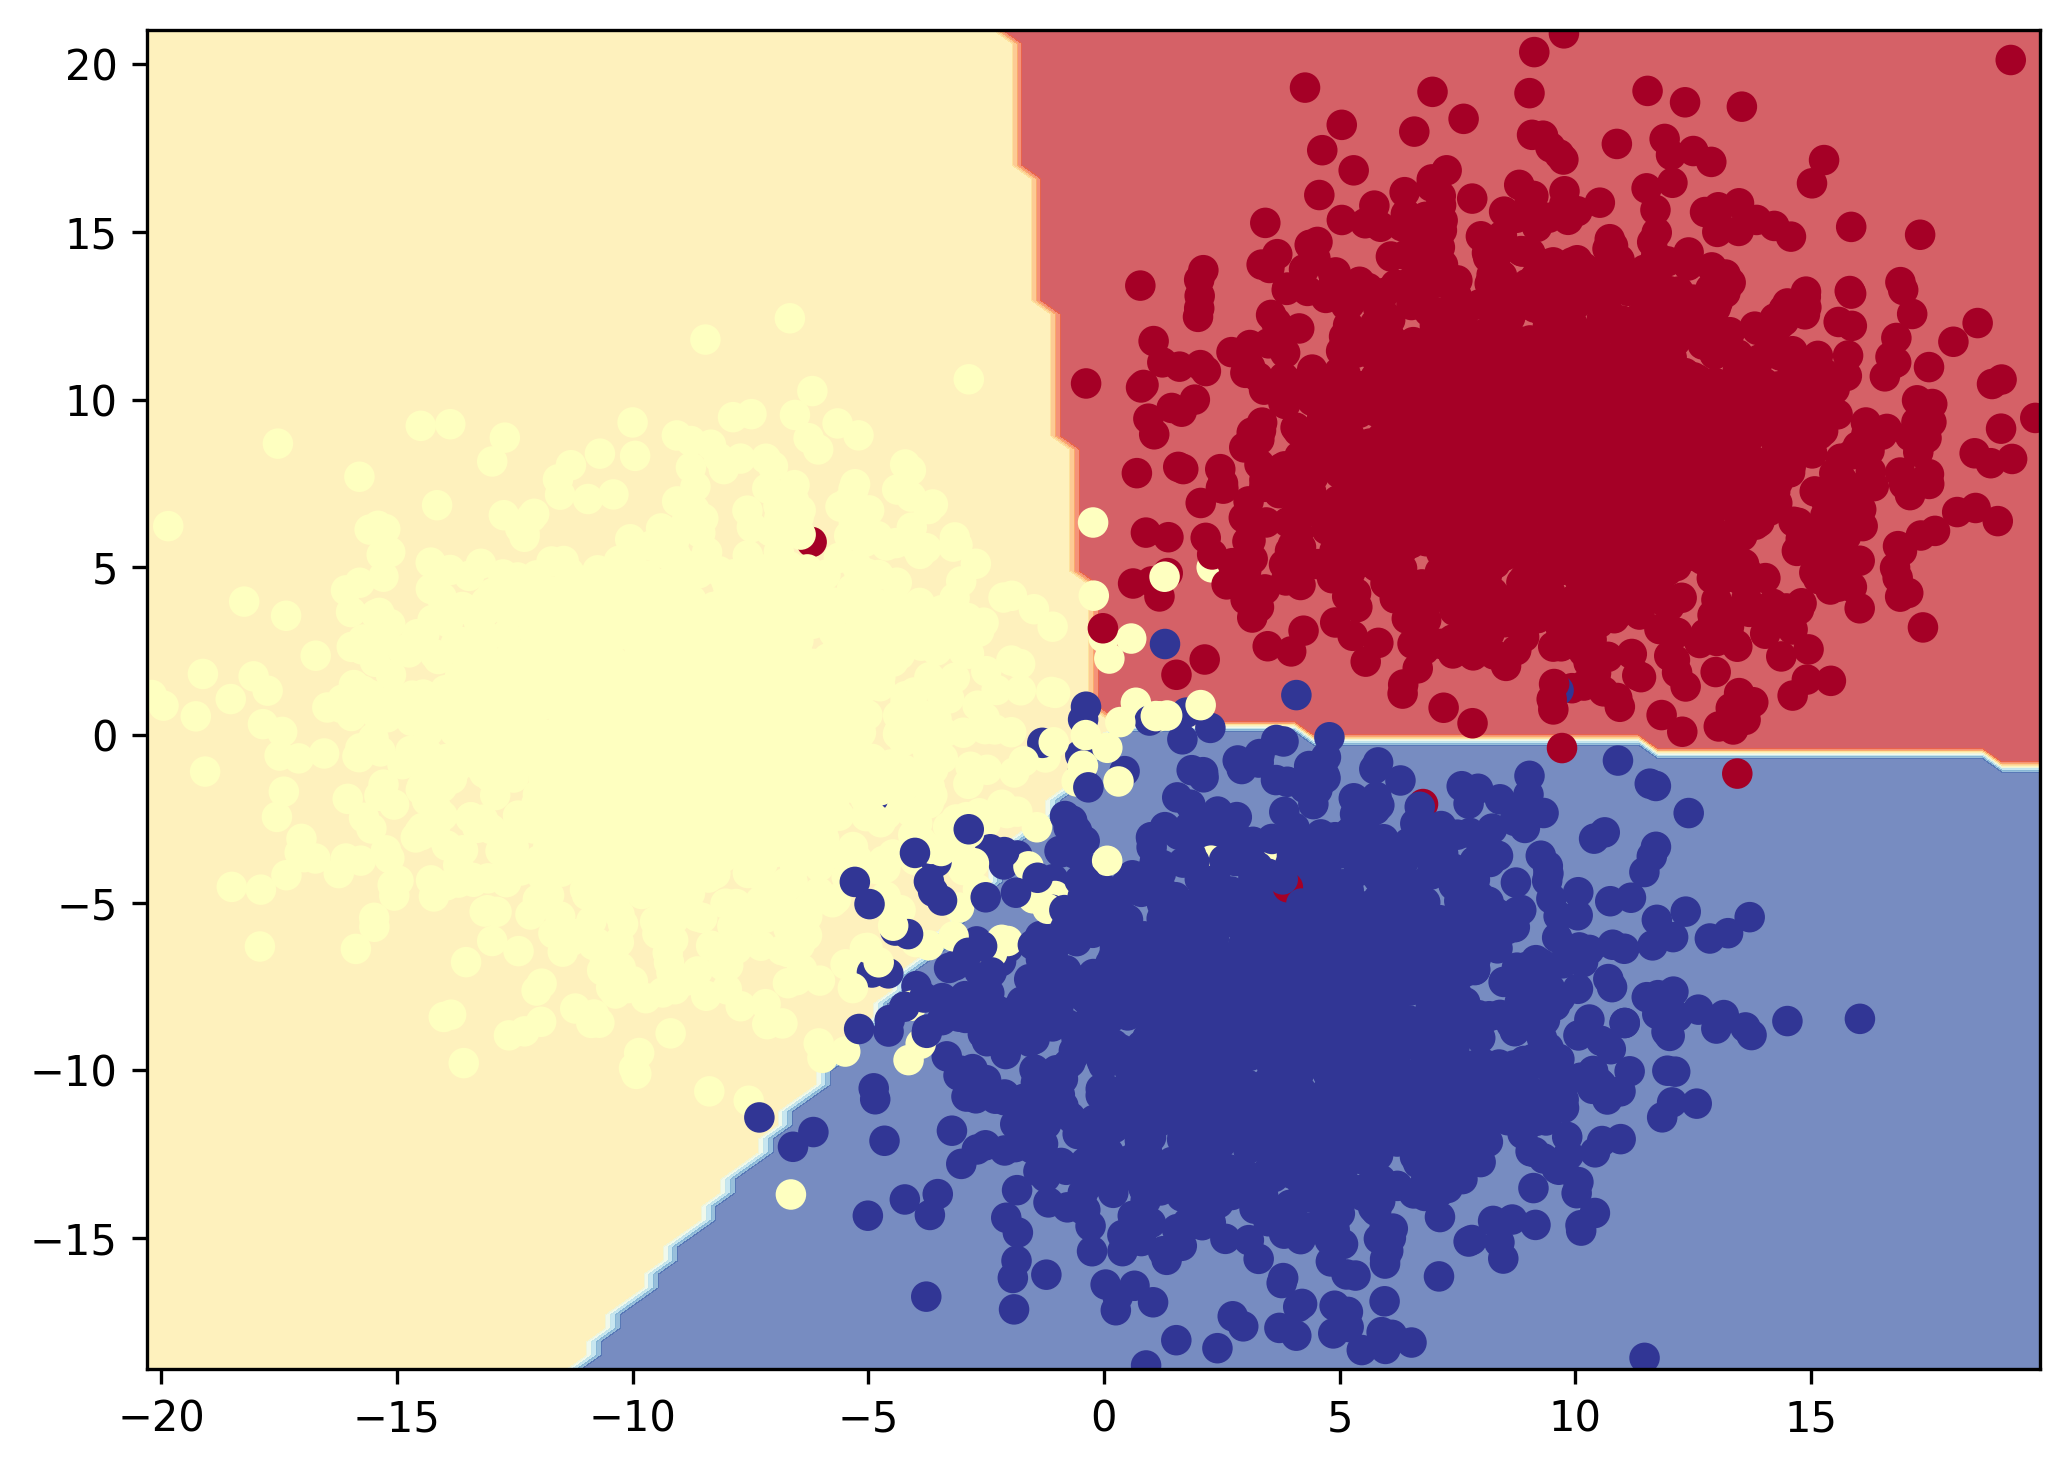

In [40]:
plot_2D_decision_boundary(X,y,model, save_path='./Plots/multiclass_classification_example_predictions.pdf')

# Example of Vanishing Gradients with `Sigmoid` on hidden layers

In [41]:
def generate_vanishing_gradient_data(n, scale=0.1, seed=123):
    np.random.seed(seed)
    x = np.random.uniform(-3,3,(n,))
    err = np.random.normal(0., scale, (n,))
    y = 0.5*(x**2) + x + err
    return x,y

In [42]:
x,y = generate_vanishing_gradient_data(1000)

x = x.reshape(-1,1)
y = y.reshape(-1,1)

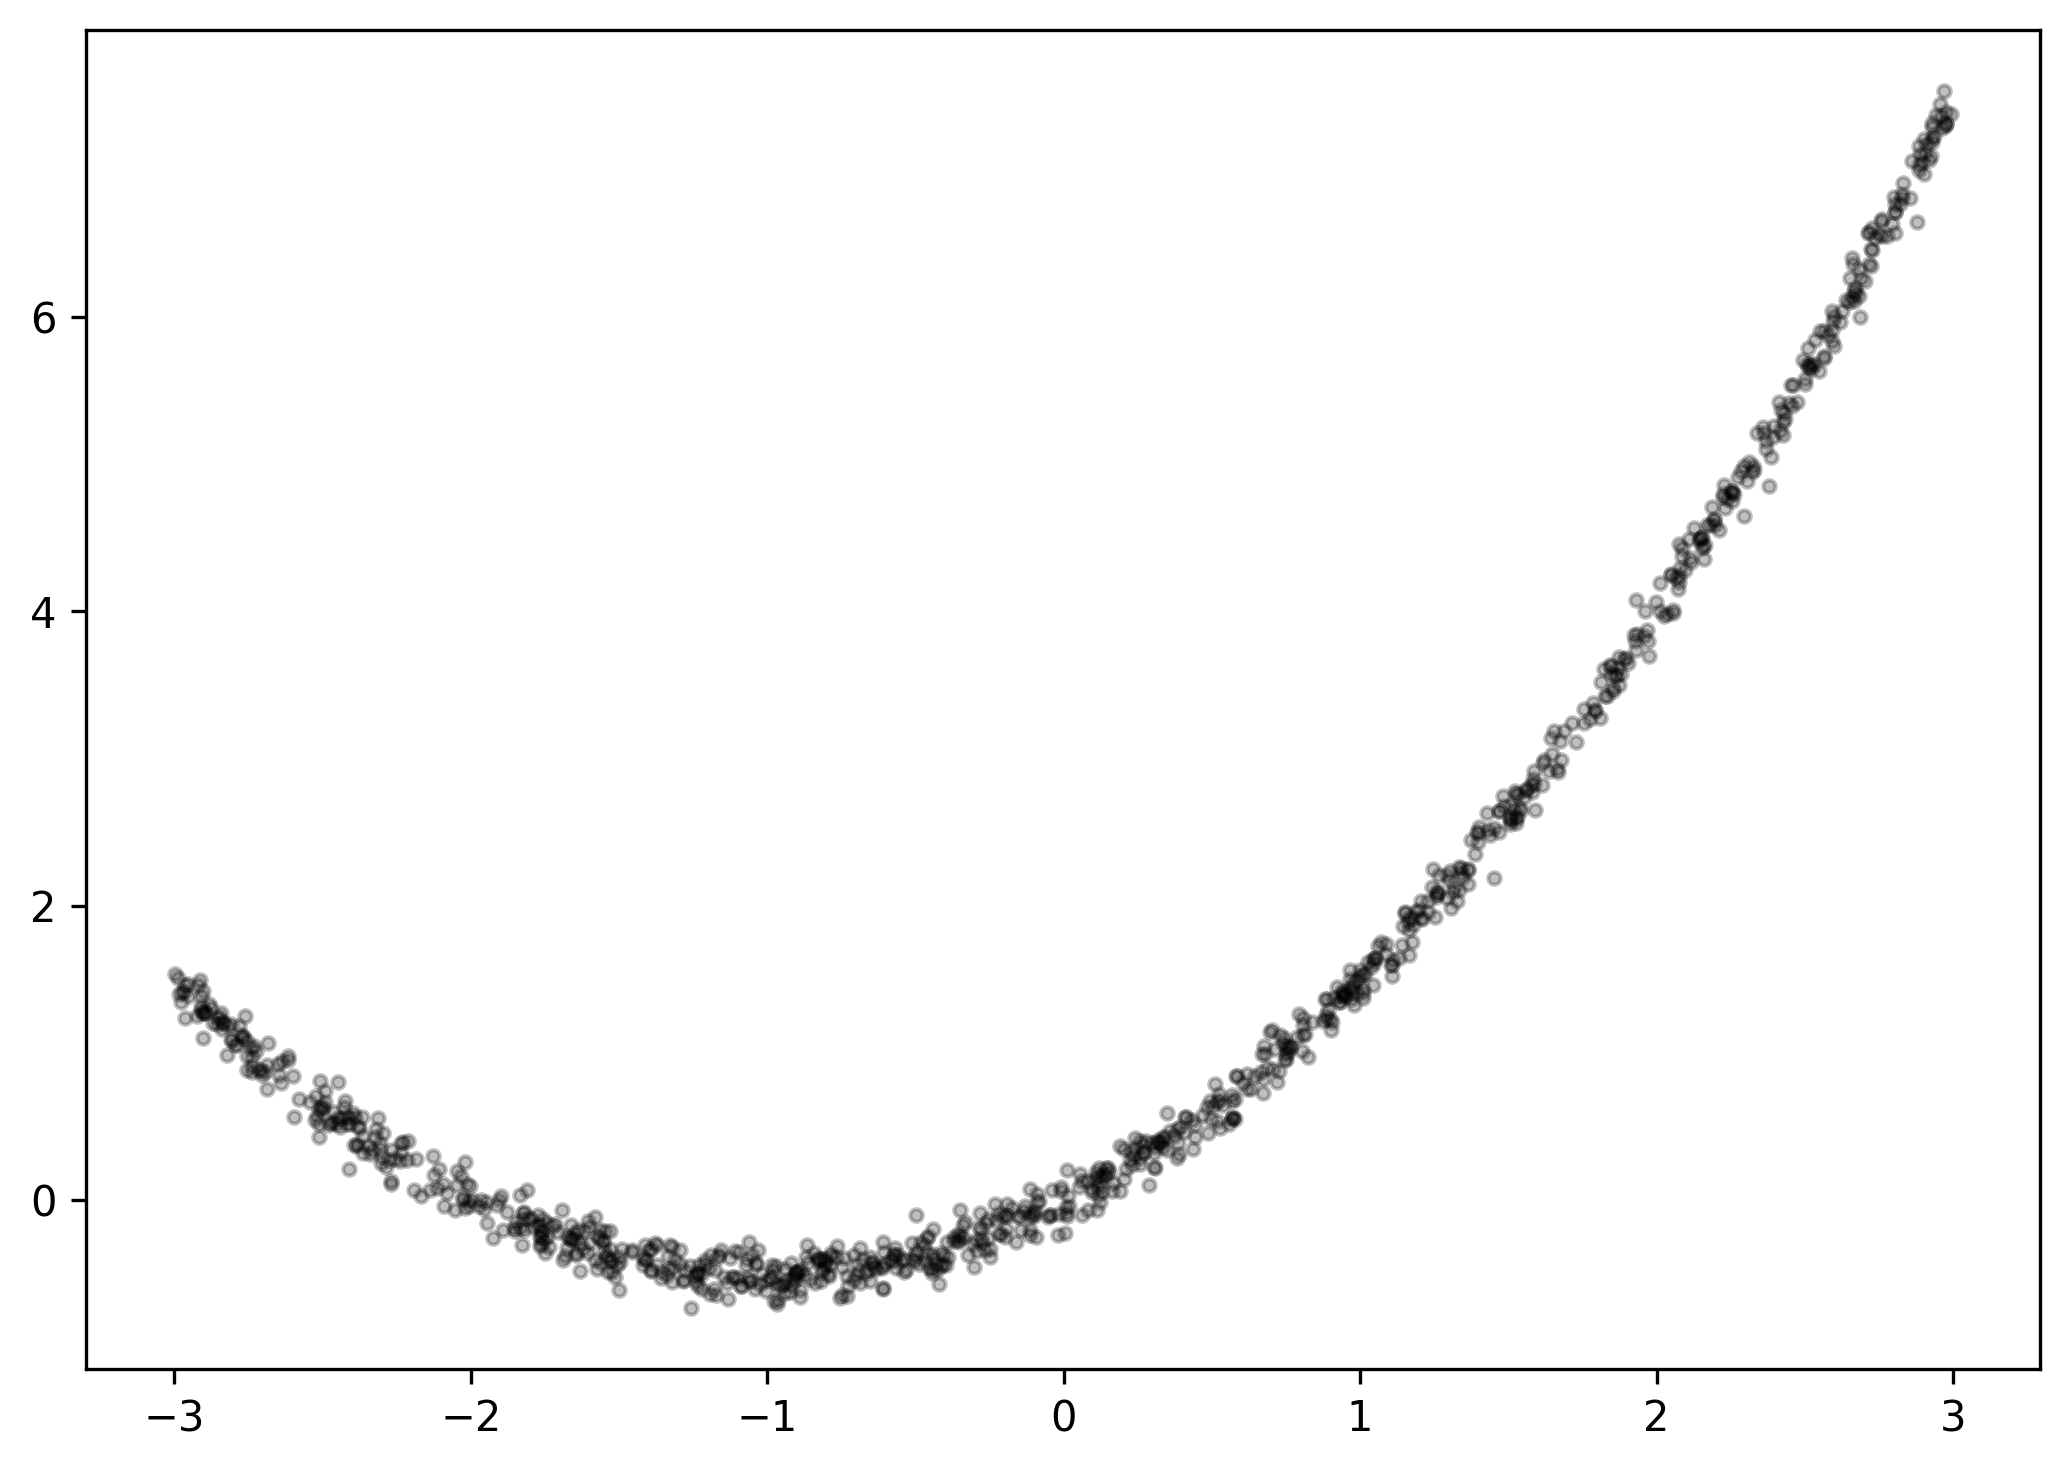

In [43]:
plt.figure(dpi=300, figsize=(7,5))
plt.scatter(x,y, c='black', alpha=0.25, marker='.')
plt.tight_layout()
plt.savefig('./Plots/vanishing_grad_data.pdf', bbox_inches='tight')
plt.show()

In [44]:
# Create model
model = Model()
 
# Add layers
model.add(Linear(1, 8))
model.add(ReLU())
model.add(Linear(8,8))
model.add(ReLU())
model.add(Linear(8,8))
model.add(ReLU())
model.add(Linear(8,8))
model.add(ReLU())
model.add(Linear(8,8))
model.add(ReLU())
model.add(Linear(8,1))

In [45]:
model.fit(X_train = x, 
          Y_train = y, 
          loss_fn = MeanAbsoluteError(),
          learning_rate = 0.01, 
          epochs = 5000,
          verbose = True)

Epoch: 0. Loss: 4.18143882345402
Epoch: 500. Loss: 0.18404920140298164
Epoch: 1000. Loss: 0.1574872651386906
Epoch: 1500. Loss: 0.14603583449862317
Epoch: 2000. Loss: 0.1339845583087028
Epoch: 2500. Loss: 0.1278397554588107
Epoch: 3000. Loss: 0.1267477827977254
Epoch: 3500. Loss: 0.1255291565232406
Epoch: 4000. Loss: 0.1223251450768837
Epoch: 4500. Loss: 0.12193342888729447


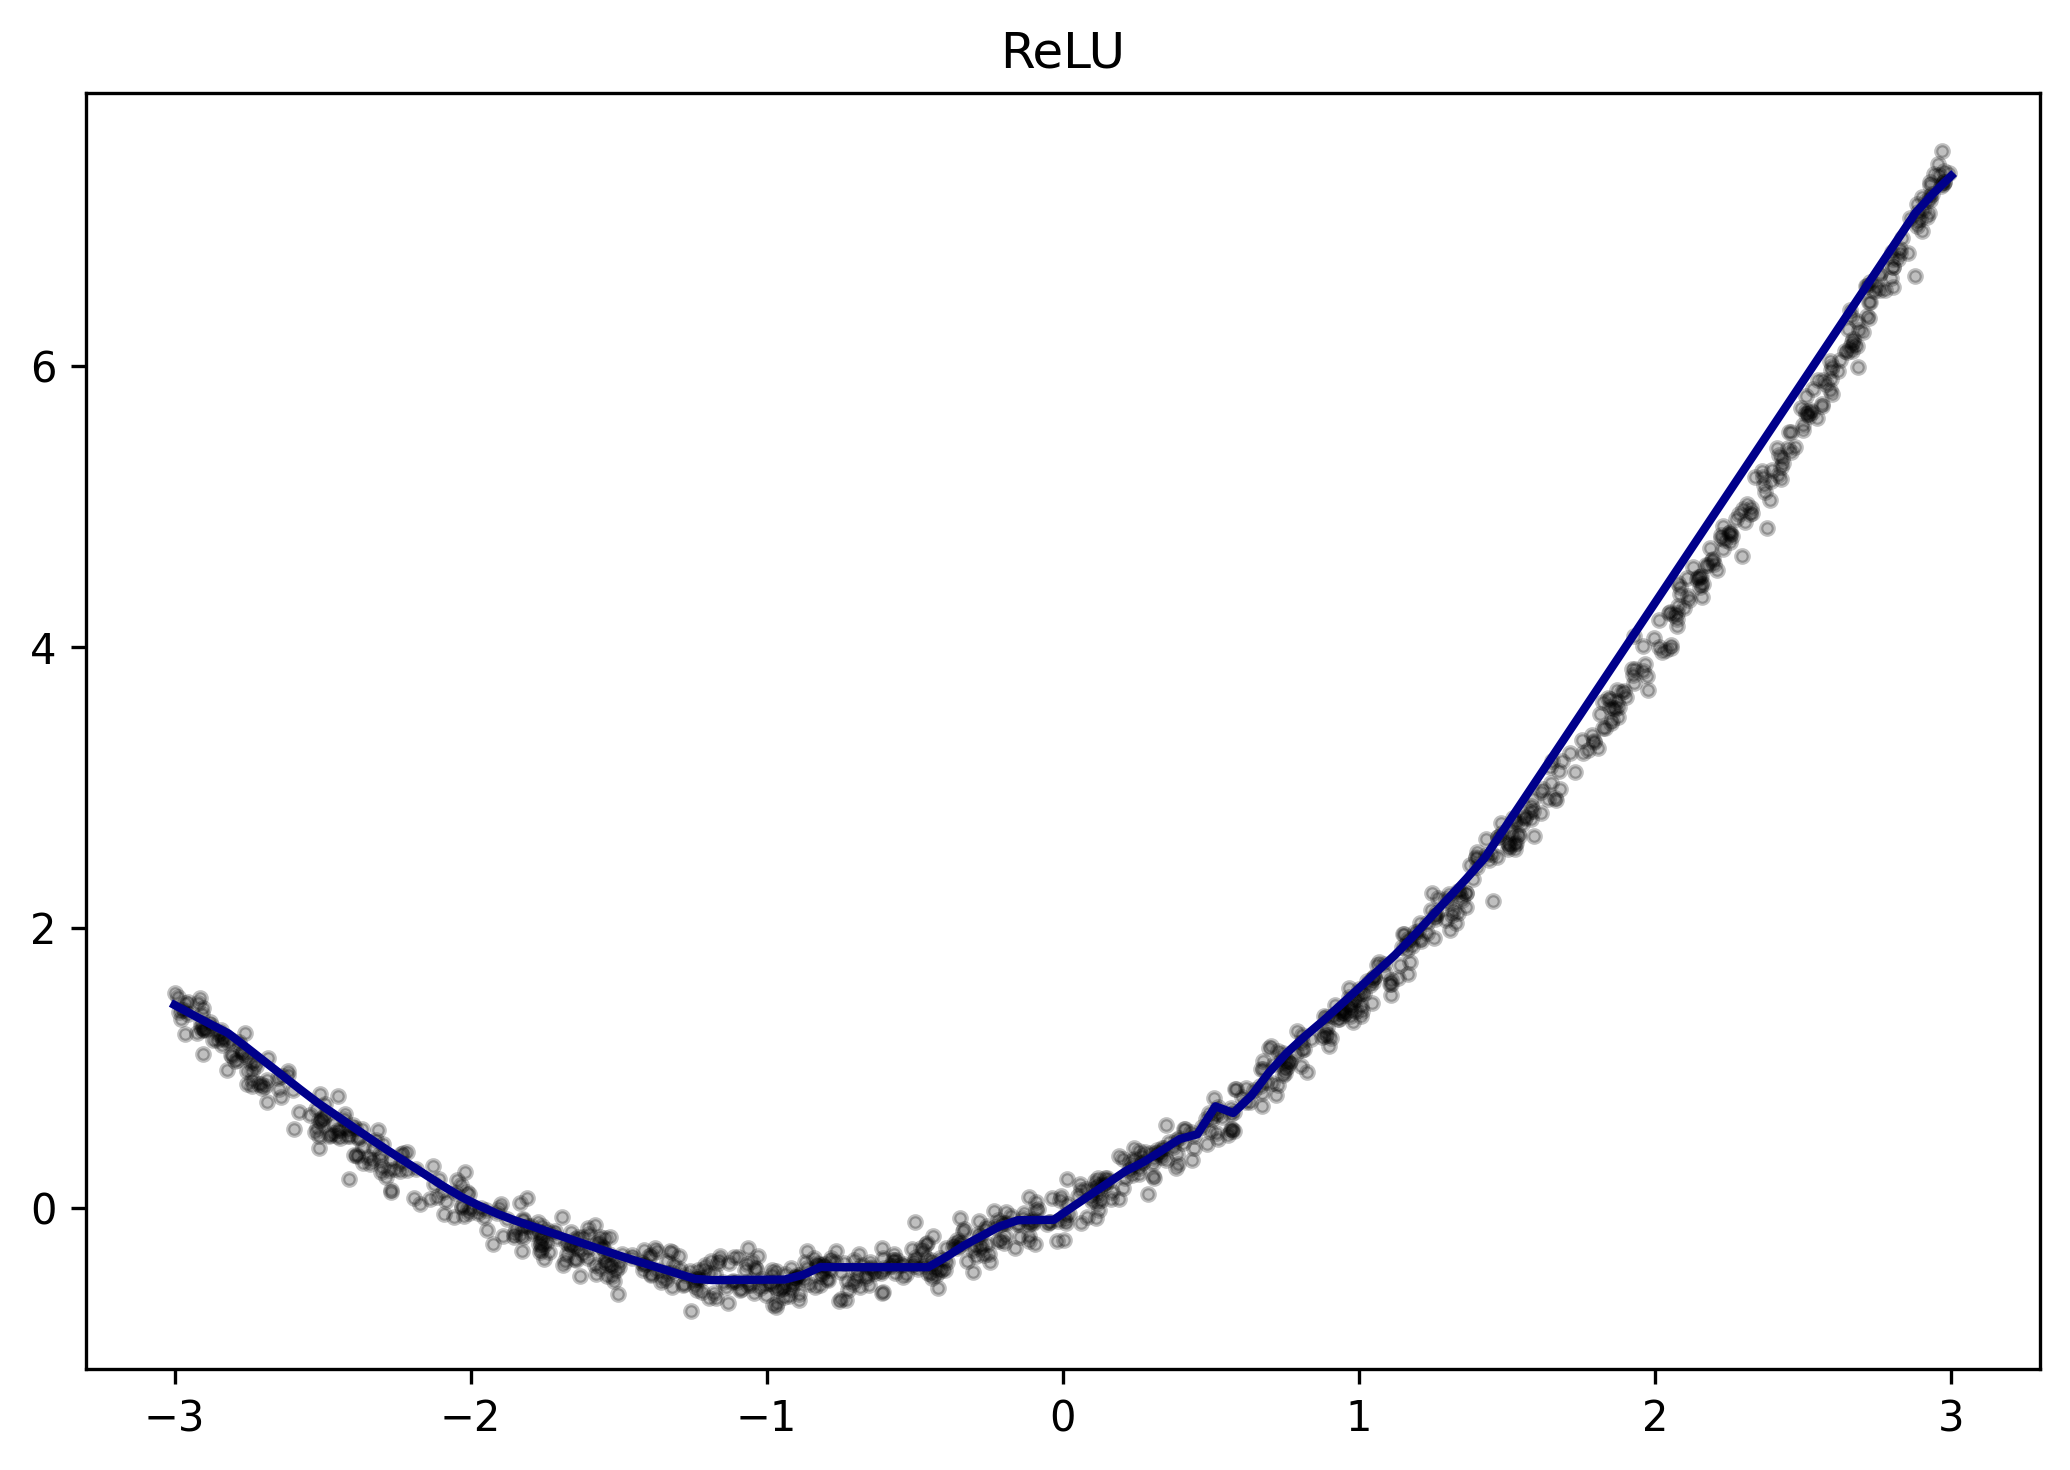

In [46]:
xseq = np.linspace(-3,3,100)
yseq = model.predict(xseq.reshape(-1,1))
plt.figure(dpi=300, figsize=(7,5))
plt.scatter(x,y, c='black', alpha=0.25, marker='.')
plt.plot(xseq, yseq.ravel(), color='darkblue', linewidth=2.0)
plt.title('ReLU')
plt.tight_layout()
plt.savefig('./Plots/vanishing_grad_pred_relu.pdf', bbox_inches='tight')
plt.show()

In [47]:
# Create model
model = Model()
 
# Add layers
model.add(Linear(1, 8))
model.add(Sigmoid())
model.add(Linear(8,8))
model.add(Sigmoid())
model.add(Linear(8,8))
model.add(Sigmoid())
model.add(Linear(8,8))
model.add(Sigmoid())
model.add(Linear(8,8))
model.add(Sigmoid())
model.add(Linear(8,1))

In [48]:
model.fit(X_train = x, 
          Y_train = y, 
          loss_fn = MeanAbsoluteError(),
          learning_rate = 0.01, 
          epochs = 5000,
          verbose = True)

Epoch: 0. Loss: 2.695975315450564
Epoch: 500. Loss: 1.6291654021832218
Epoch: 1000. Loss: 1.6219725635618703
Epoch: 1500. Loss: 1.6154147490015172
Epoch: 2000. Loss: 1.6073603028840098
Epoch: 2500. Loss: 1.5946620966829015
Epoch: 3000. Loss: 1.569173609480313
Epoch: 3500. Loss: 1.503705308014225
Epoch: 4000. Loss: 1.3379725441708314
Epoch: 4500. Loss: 1.0564394005856386


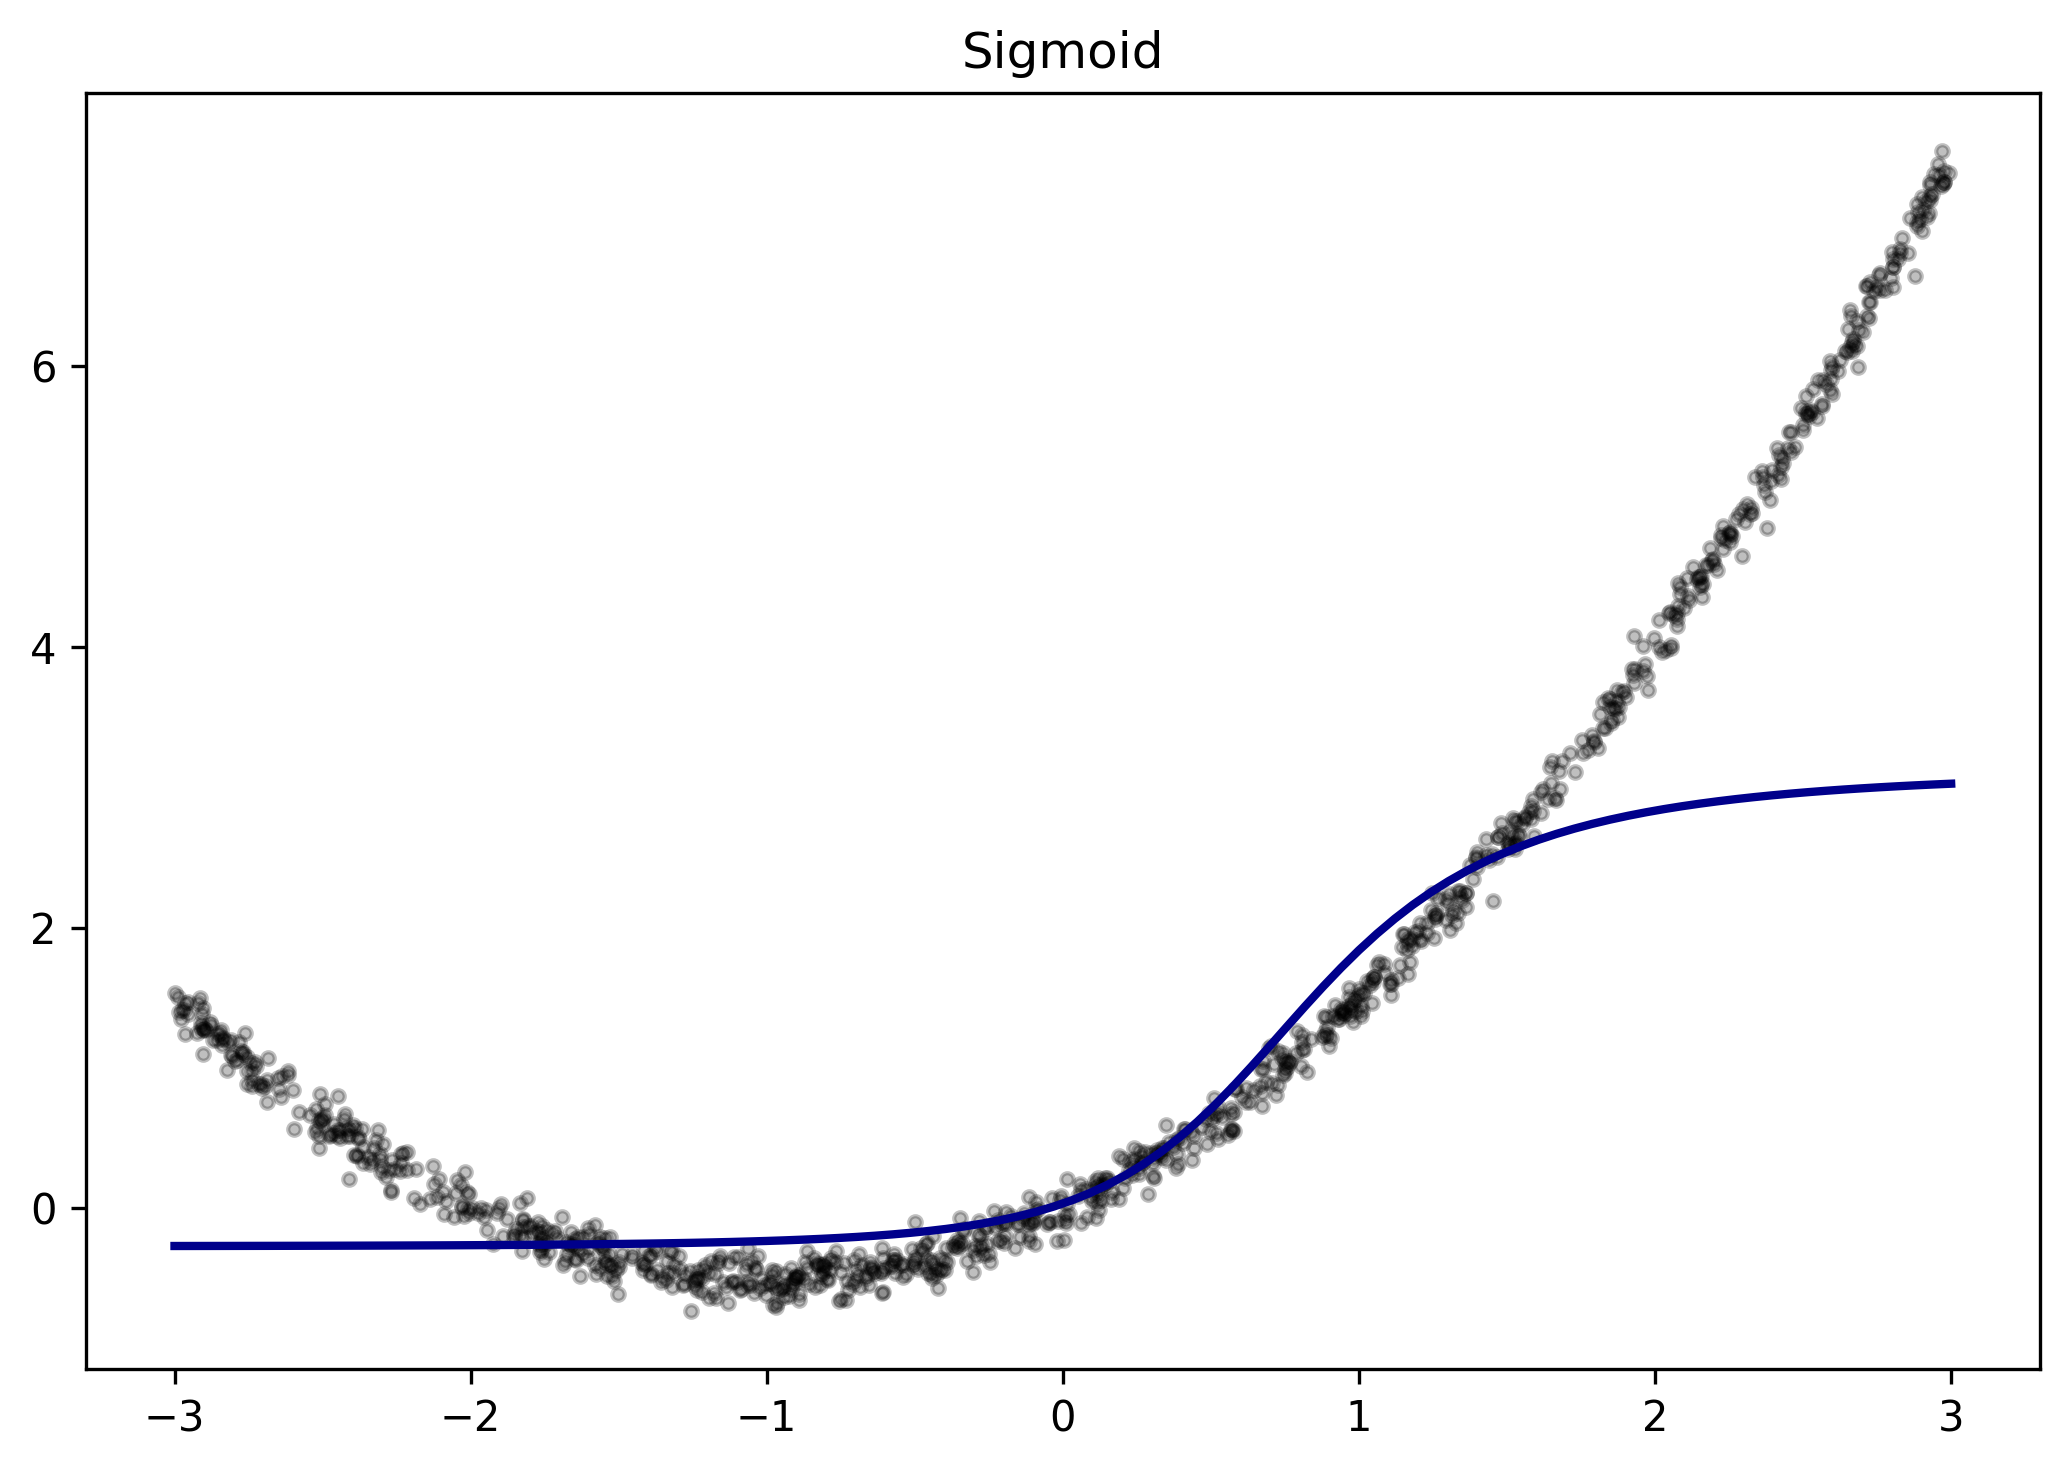

In [49]:
xseq = np.linspace(-3,3,100)
yseq = model.predict(xseq.reshape(-1,1))
plt.figure(dpi=300, figsize=(7,5))
plt.scatter(x,y, c='black', alpha=0.25, marker='.')
plt.plot(xseq, yseq.ravel(), color='darkblue', linewidth=2.0)
plt.title('Sigmoid')
plt.tight_layout()
plt.savefig('./Plots/vanishing_grad_pred_sigmoid.pdf', bbox_inches='tight')
plt.show()